In [111]:
import matplotlib.pyplot as plt, numpy as np, scipy.stats as stats
from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import minimize

plt.style.use('../astro406/mplstyle_cb.txt')
%config InlineBackend.figure_format = 'retina'

In [ ]:
hdul = fits.open('data/SMC_SNR/b0886.norm.dc.fits')
flux = hdul[0].data
if 'CD1_1' in list(hdul[0].header.keys()):
    wave = hdul[0].header['CRVAL1'] + hdul[0].header['CD1_1'] * (np.arange(hdul[0].header['NAXIS1']) - hdul[0].header['CRPIX1'] + 1)
else: wave = hdul[0].header['CRVAL1'] + hdul[0].header['CDELT1'] * (np.arange(hdul[0].header['NAXIS1']) - hdul[0].header['CRPIX1'] + 1)

hdul = fits.open('data/SMC_SNR/b0886_var.norm.dc.fits')
noise = np.sqrt(hdul[0].data)  # noise is the sqrt of the variance

In [6]:
# function to make the resulting fitted spectrum
def gaussians(x, params):
    y = np.zeros_like(x)  # initialize line
    if len(params) == 0:  # handle empty params (where there are no peaks)
        return y  # if there are no gaussians, just return the continuum
    for i in range(0, len(params), 3):
        amp, mean, std = params[i], params[i+1], params[i+2]  # params variable contains [amplitude, mean, stddev] of the gaussians
        y += amp * np.exp(-0.5 * ((x - mean) / std) ** 2)  # add a gaussian with the above parameters to the line
    return y

# function to be minimized
def negloglikelihood(params, x, y, errors):
    model = gaussians(x, params)  # create the multi-gaussian line
    residuals = y - model  # the residuals between the spectrum and the gaussian line
    return 0.5 * np.sum((residuals / errors) ** 2) + np.sum(np.log(np.sqrt(2 * np.pi) * errors))

In [151]:
# function to fit spectra
def gaussfit(spectrum, noise, statistics=False):
    
    spectrum -= np.median(spectrum)  # normalize continuum to zero
    smooth = savgol_filter(spectrum, window_length=11, polyorder=2)  # used only to make detecting peaks easier

    peaks, properties = find_peaks(smooth, height=1.75*noise, prominence=1.5*noise, width=np.diff(wave)[0],  # arbitrary
                                   distance=5)  # effective resolution of IFUM, 5 angstroms is 51 index units
    stddevs = np.diff(wave)[0]*properties['widths']/(2*(2*np.log(2))**0.5)  # stddev = FWHM / 2*sqrt(2*ln(2))

    if len(peaks) == 0:  # for the fits where no gaussians are fitted
        class nothing: x=np.array([])
        return nothing()#, 1, 0.05  # this means that our line will just be the same as the continuum line

    init=[]; lower=[]; upper=[]  # initial guess, lower bounds, upper bounds for least_squares
    for p,sig in zip(peaks, stddevs):
        amp=spectrum[p]; mean=wave[p]  # the amplitude and wavelength have already been predicted from find_peaks, sigma is a guess
        init.extend([amp, mean, sig])
        # bounds: mean must be within the wavelength range, and only fitting emission lines
        lower.extend([0, mean-2.5, 0])
        upper.extend([np.inf, mean+2.5, np.inf]) 
    
    result = minimize(negloglikelihood, init, args=(wave, spectrum, noise), bounds=(zip(lower,upper)), options={'maxiter': 2000})

    if statistics:
        # ========== analysis of fit ==========
        # reduced chi2
        residuals = spectrum - gaussians(wave, result.x)
        chisquare = np.sum((residuals / noise) ** 2)
        dof = len(spectrum) - len(result.x)  # len(result.x) is the number of fitted parameters

        # kolmogorov-smirnov test
        mask = (gaussians(wave, result.x) > 7)  # only compare the gaussian fits, not the continuum
        statistic, pvalue = stats.ks_2samp(spectrum[mask], gaussians(wave, result.x)[mask]) 
        return result, chisquare/dof, pvalue
    
    else: return result

/var/folders/s4/tddv5hsj2hz5y6yvpjzy963m0000gn/T/ipykernel_1777/163716262.py:8: RuntimeWarning: divide by zero encountered in divide
  y += amp * np.exp(-0.5 * ((x - mean) / std) ** 2)  # add a gaussian with the above parameters to the line


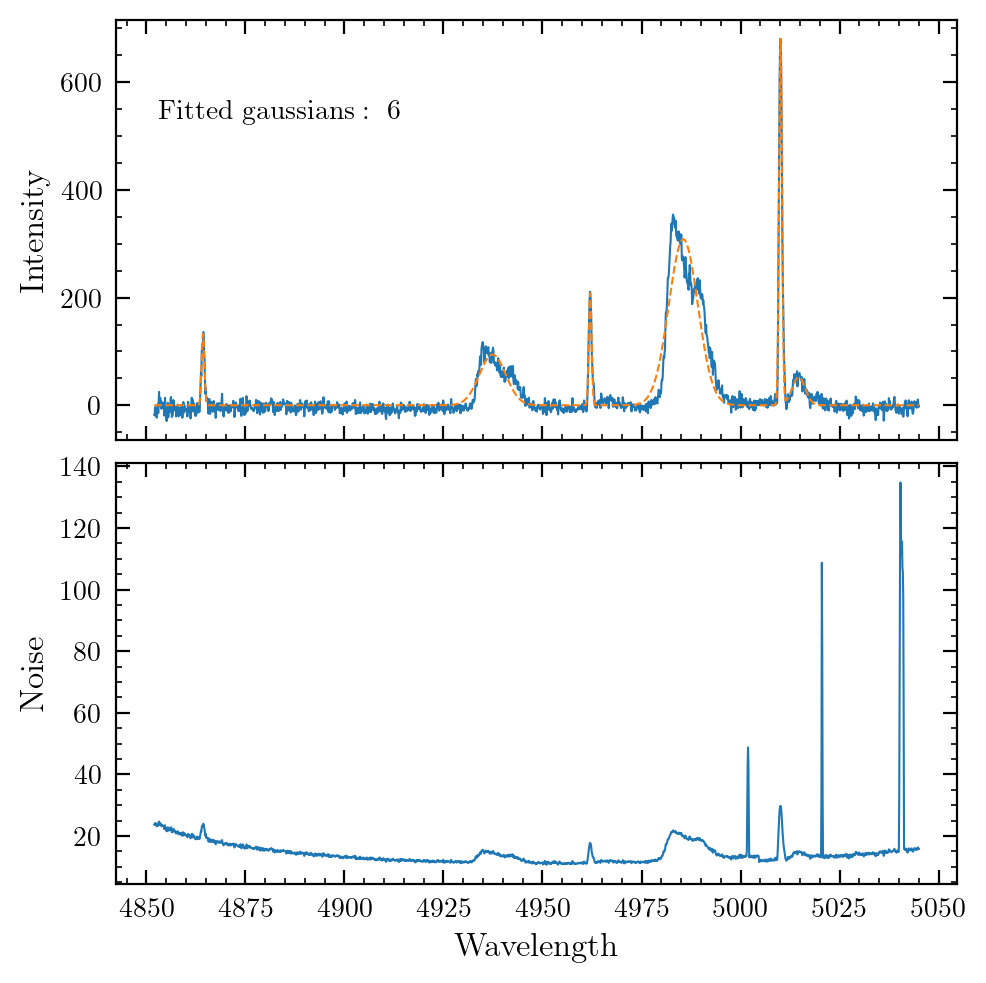

In [160]:
n=190
model = gaussfit(flux[n], noise[n])
fig,ax = plt.subplots(2,1, sharex=True, layout='compressed'); fig.set_figwidth(7)

ax[0].plot(wave,flux[n],lw=0.75, label=r'$\mathrm{Spectrum}$')
ax[0].plot(wave,gaussians(wave, model.x),lw=0.75, label=r'$\mathrm{Multi\ Gaussian\ Fit}$', ls='dashed')
ax[1].plot(wave, noise[n], lw=0.75)
# for m in model.x[1::3]: ax[0].axvline(m, lw=0.75, c='k')
for a in ax: a.set_box_aspect(0.5)
ax[1].set_xlabel(r'$\rm Wavelength$')
ax[0].set_ylabel(r'$\rm Intensity$'); ax[1].set_ylabel(r'$\rm Noise$')
ax[0].text(0.05,0.75,rf'$\rm Fitted\ gaussians:\ {len(model.x)//3}$', ha='left',va='bottom',transform=ax[0].transAxes);